In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# from sklearn import decision_tree
from sklearn import metrics

In [2]:
# 読み込み→floatへ→平均補完orドロップ→intへ変換
df_test = pd.read_csv('test.csv', index_col='PassengerId', dtype='object')
df_test.Age = df_test.Age.astype(float)# Ageは、1より小さいなら小数らしいが、どうでもいいのでintにしてしまう
df_test.Age.fillna(df_test.Age.mean(), inplace=True)
df_test.Age = df_test.Age.astype(int)
# print(df_test.isnull().sum(), 'test\n')
df_train = pd.read_csv('train.csv', index_col='PassengerId', dtype='object')
df_train.Age = df_train.Age.astype(float)
df_train.dropna(subset=['Age', 'Embarked'], inplace=True)
df_train.Age = df_train.Age.astype(int)
# print(df_train.isnull().sum(), 'train\n')

# Xとyに分割
X_test = df_test
X_train = df_train.drop(columns=['Survived'])
y_train = df_train['Survived'].copy().astype(int)

# Xを結合して、前処理を行う
df_X = pd.concat([X_train, X_test])[['Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch']]# 892行目からテストデータ
df_X.Sex = (df_X.Sex == 'male').astype(int)# maleなら1に
df_X.loc[:, ['Pclass', 'SibSp', 'Parch']] = df_X.loc[:, ['Pclass', 'SibSp', 'Parch']].apply(lambda x: x.astype(int))
# S = 1, C = 0.5, Q = 0
# df_X.Embarked = df_X.Embarked.apply(lambda x: 0.5 if x=='C' else float(x=='S'))
df_X = pd.get_dummies(df_X, drop_first=True)
# Embarked、0, 0.5, 1よりdummiesのほうが高い
# ただ、3列にしたからその分影響がでかくなっているか？drop_firstのほうがいいかも
# Standard Scaling @ Age
ss = StandardScaler()
std_age = ss.fit_transform(df_X[['Age']])
df_X.Age = std_age
# Pclassを-1から1にしてみる、しないほうがいい
# df_X.Pclass = df_X.Pclass - 2
# get_dummiesにするのと分類の精度は変わるか？

# df_X.isnull().sum()# 欠損値の処理は完了
print(df_X.dtypes)
# print(y_train.dtypes)

# Xを分割
X_train = df_X.loc[1:891].copy()
X_test = df_X.loc[892:].copy()
train_master = pd.concat([X_train, y_train], axis=1)# グラフ書くためにyが書いてあるdfが必要だから

Pclass          int32
Sex             int32
Age           float64
SibSp           int32
Parch           int32
Embarked_Q      uint8
Embarked_S      uint8
dtype: object


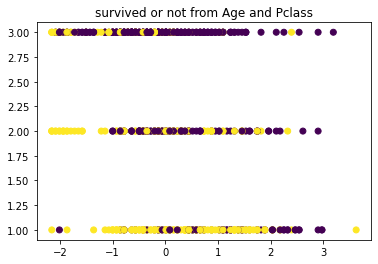

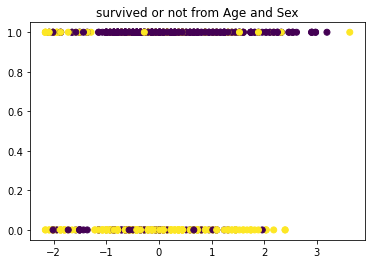

In [3]:
def make_scatter(xy_list):
    for x, y in xy_list:
        plt.scatter(X_train[x], X_train[y], c=y_train);
        plt.title('survived or not from {} and {}'.format(x, y))
        plt.show();

make_scatter([('Age', 'Pclass'), ('Age', 'Sex')])
# Sex, Age, Pclass, Embarkedあたりが使えそう


def make_barplot(column_list):# column_listにわたすと
    for name in column_list:
        sr = train_master.groupby(name).apply(lambda x: x.Survived.sum()/x.Survived.count())
        plt.bar(sr.index, sr)
        plt.title('the ratio of survivors from each {}'.format(name))
        plt.show();

# make_barplot(['Embarked', 'Pclass', 'SibSp', 'Parch'])

In [4]:
# ロジスティック回帰@accuracy 75-77%、まあデータ少ないからね
lr = LogisticRegression()
lr.fit(X_train, y_train)
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l2',
#                    random_state=None, solver='warn', tol=0.0001, verbose=0,
#                    warm_start=False)
sr_result = lr.predict(X_test)

In [5]:
df_output = pd.read_csv('gender_submission.csv')
df_output.Survived = sr_result
df_output.to_csv('titanic_output.csv', index=False)
df_output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [6]:
# 学習データをそのまま入力したときにこのモデルでの正確率を得ることで、過学習していないかを見てみよう
sr_train_result = lr.predict(X_train)
df_train_result = pd.DataFrame(y_train).copy()
df_train_result.Survived = sr_train_result

# accuracy_score(y_true, y_pred)、accuracy_score, recall_score, f1_score(両者の中庸であるf値)がある
metrics.recall_score(y_train, df_train_result)
# 意外と低いな、そもそもデータが少なくて学習できてないか？
# SVMでの結果がきになる

0.71875

In [7]:
# 上のセルのaccuracy_scoreと同じこと
lr.score(X_train, y_train)

0.8047752808988764

# 正規化されたAge

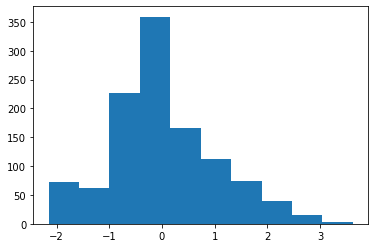

In [8]:
plt.hist(df_X.Age);

-6.759587972939006e-17 1.0


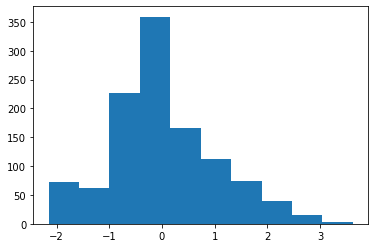

In [9]:
print(std_age.mean(), std_age.std())
plt.hist(std_age);
# 標準化って分布は変わらないんだ。最大、最小、データ同士の間隔を凝縮してるので、最大と最小は
# コントロールできない。対して、minmaxscalerはコントロールできるってことね